In [62]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob

In [63]:
methods = [
    "s3",
    "dynamodb",
    "auto",
]

dfs = []

for method in methods:
  df = pd.concat([pd.read_json(f, lines=True) for f in glob.glob(f'../results/auto/{method}.jsonl')], ignore_index=True)
  df['method'] = method
  dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [64]:
df.head(1)

,receiver_start_delay,total_time,message_size,sender_usage,receiver_usage,method
0,0.015794,0.270284,1,"{'s3:PutObject': 1, 's3:GetObject': 2, 's3:Del...","{'s3:GetObject': 2, 's3:PutObject': 1, 's3:Del...",s3


In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   receiver_start_delay  180 non-null    float64
 1   total_time            180 non-null    float64
 2   message_size          180 non-null    int64  
 3   sender_usage          180 non-null    object 
 4   receiver_usage        180 non-null    object 
 5   method                180 non-null    object 
dtypes: float64(2), int64(1), object(3)
memory usage: 8.6+ KB


In [66]:
# calculate latency
df['latency'] = df['total_time'] * 1000 / 2

# sum usage
def sum_usage(a, b):
    return {k: a.get(k, 0) + b.get(k, 0) for k in set(a) | set(b)}

df['usage'] = df.apply(
    lambda x: sum_usage(x['sender_usage'], x['receiver_usage']), axis=1
)

df['size'] = df['message_size'].astype('category')

# map size values
size_map = {
  1: '1B',
  1000: '1kB',
  10000: '10kB',
  100000: '100kB',
  1000000: '1MB',
  10000000: '10MB',
  100000000: '100MB',
  1000000000: '1GB',
}

df['size'] = df['size'].map(size_map)

df = df[['method', 'latency', 'size', 'usage']]

In [67]:
df

,method,latency,size,usage
0,s3,135.142207,1B,"{'s3:PutObject': 2, 's3:GetObject': 4, 's3:Del..."
1,s3,64.645767,1B,"{'s3:PutObject': 2, 's3:GetObject': 4, 's3:Del..."
2,s3,66.353321,1B,"{'s3:PutObject': 2, 's3:GetObject': 5, 's3:Del..."
3,s3,54.611802,1B,"{'s3:PutObject': 2, 's3:GetObject': 4, 's3:Del..."
4,s3,65.309405,1B,"{'s3:PutObject': 2, 's3:GetObject': 6, 's3:Del..."
...,...,...,...,...
175,auto,1898.063302,100MB,"{'s3:PutObject': 2, 's3:GetObject': 161, 's3:D..."
176,auto,1858.399391,100MB,"{'s3:PutObject': 2, 's3:GetObject': 152, 's3:D..."
177,auto,2081.294060,100MB,"{'s3:PutObject': 2, 's3:GetObject': 169, 's3:D..."
178,auto,1962.457776,100MB,"{'s3:PutObject': 2, 's3:GetObject': 160, 's3:D..."


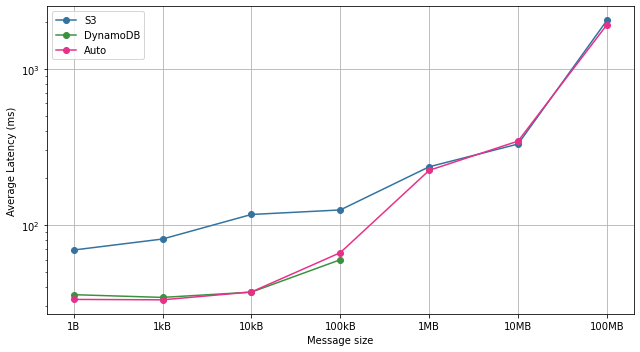

In [81]:
plt.figure(figsize=(9, 5))

plt.rcParams['font.family'] = 'Linux Libertine'
plt.rcParams['svg.fonttype'] = 'none'

a = df.query('method == "s3"').groupby('size').mean()
plt.plot(a.index, a['latency'], 'o-', c='#33739F')
a = df.query('method == "dynamodb"').groupby('size').mean()
plt.plot(a.index, a['latency'], 'o-', c="#3B923E")

a = df.query('method == "auto"').groupby('size').mean()
plt.plot(a.index, a['latency'], 'o-', c="#E6318A")


plt.legend(['S3', 'DynamoDB', 'Auto'])
plt.ylabel('Average Latency (ms)')
plt.xlabel('Message size')
# plt.yticks([0.1, 1, 10, 100, 1000, 10_000], ['$0.10', '$1', '$10', '$100', '$1000', '$10000'])
plt.grid()
plt.yscale('log')

plt.tight_layout()
plt.savefig("img/auto.svg")
